# Unet
The model design includes two learning stages. In stage I, each input volume goes through a separate stack of convolutional layers. In stage II, feature maps resulting from stage I are merged, and the results are fed to a deep learning model to arrive at the final outputs.

![title](img/f1.png)

Source: Sun et al. 2019: "Combining Physically Based Modeling and Deep Learning for Fusing GRACE Satellite Data: Can We Learn From Mismatch?", fig. 3

In [18]:
#!pip install tensorflow xarray numpy wget
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/stages.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/unet.py

import numpy as np
import xarray as xr

from keras.models import Model
from keras.optimizers import SGD
from stages import stage1
from unet import unet
from full_models import unet_full
from loss import custom_loss

#### 1. Shallow learning (Stage 1)
For Unet and SegnetLite models, stage I shallow learning includes a single convolutional layer with 16 filters for each type of predictors, the outputs of which are then merged and provided as inputs to the respective deep learning model.

In [2]:
stage1_model = stage1(16)

stage1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                              

#### 2. Unet

In [3]:
unet_model = unet((128,128,48))

In [4]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 48)]       0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 32)         13856     ['input_4[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_4[0][0]']            
 D)                                                                                         

#### 3. Combined model (Stage 2)

In [5]:
#full_model = Model(inputs=stage1_model.inputs, outputs=unet_model(stage1_model.outputs))
full_model = unet_full(16)

In [6]:
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking_3 (Masking)         (None, 128, 128, 3)          0         ['input_5[0][0]']             
                                                                                            

#### 4. Model training
Out of a total of 177 monthly data available for the study period, 125 months or 70% is used for training and the rest for testing.

In [7]:
precip_train = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(3,127)])
temp_train = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(3,127)])
twsa_train = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(3,127)])

precip_test = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(127,177)])
temp_test = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(127,177)])
twsa_test = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(127,177)])

mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')
mismatch = mismatch_ds['norm_mismatch'].to_numpy()[..., np.newaxis]
mismatch_train = mismatch[3:127]
mismatch_test = mismatch[127:177]

print(f'Number of training examples = {precip_train.shape[0]}')
print(f'Number of test examples = {precip_test.shape[0]}')

print(f'Training input shape: {precip_train.shape}')
print(f'Training output shape: {mismatch_train.shape}')
print(f'Test input shape: {precip_test.shape}')
print(f'Test output shape: {mismatch_test.shape}')

Number of training examples = 124
Number of test examples = 50
Training input shape: (124, 128, 128, 3)
Training output shape: (124, 128, 128, 1)
Test input shape: (50, 128, 128, 3)
Test output shape: (50, 128, 128, 1)


In [21]:
full_model.compile(optimizer = SGD(learning_rate = 0.01, weight_decay=1e-6, momentum=0.9, clipnorm=10.0), loss = custom_loss, metrics = [ 'mean_squared_error' ])
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking_3 (Masking)         (None, 128, 128, 3)          0         ['input_5[0][0]']             
                                                                                            

In [22]:
full_model.fit(x=[precip_train, temp_train, twsa_train], y=mismatch_train, epochs = 60, batch_size = 5)

Epoch 1/60
25/25 [==============================] - 10s 343ms/step - loss: 0.9690 - mean_squared_error: 0.5819
Epoch 2/60
25/25 [==============================] - 9s 369ms/step - loss: 0.7496 - mean_squared_error: 0.4086
Epoch 3/60
25/25 [==============================] - 10s 387ms/step - loss: 0.7381 - mean_squared_error: 0.3810
Epoch 4/60
25/25 [==============================] - 10s 403ms/step - loss: 0.6864 - mean_squared_error: 0.3746
Epoch 5/60
25/25 [==============================] - 10s 413ms/step - loss: 0.6921 - mean_squared_error: 0.3717
Epoch 6/60
25/25 [==============================] - 10s 406ms/step - loss: 0.7153 - mean_squared_error: 0.3773
Epoch 7/60
25/25 [==============================] - 10s 407ms/step - loss: 0.6823 - mean_squared_error: 0.3664
Epoch 8/60
25/25 [==============================] - 10s 410ms/step - loss: 0.6733 - mean_squared_error: 0.3601
Epoch 9/60
25/25 [==============================] - 10s 412ms/step - loss: 0.6849 - mean_squared_error: 0.3566
Ep

In [23]:
preds = full_model.evaluate([precip_test, temp_test, twsa_test], mismatch_test, batch_size=5)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 2s 138ms/step - loss: 1.3429 - mean_squared_error: 0.5288
Loss = 1.342942476272583
Test Accuracy = 0.5288352370262146


In [24]:
pred_mismatch = full_model.predict([precip_test, temp_test, twsa_test], batch_size=5)

10/10 [==============================] - 2s 139ms/step


In [25]:
pred_mismatch.shape

(50, 128, 128, 1)

In [26]:
mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')

In [27]:
pred_mismatch_da = xr.DataArray(np.squeeze(pred_mismatch), coords={'time': mismatch_ds['time'][127:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])

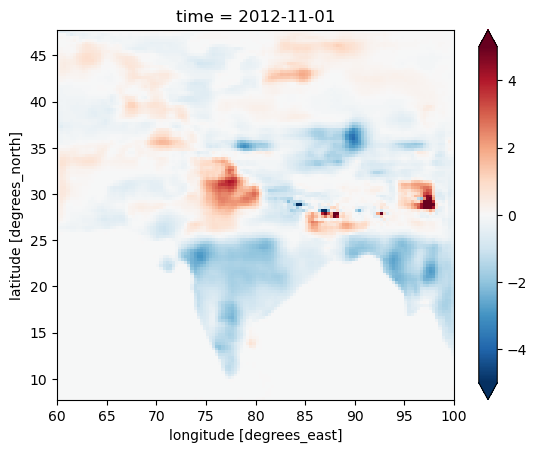

In [28]:
pred_mismatch_da[0,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

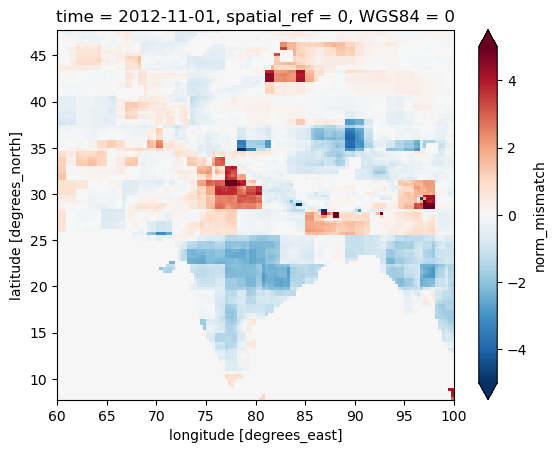

In [29]:
mds = mismatch_ds.transpose('time', 'lat', 'lon')
mds['norm_mismatch'][127,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

#### 5. Save

In [30]:
# retrieve mean and std of the normalised mismatch to denormalize the output
diff_mean = mismatch_ds['norm_mismatch'].attrs['diff_mean']
diff_std = mismatch_ds['norm_mismatch'].attrs['diff_std']

In [31]:
full_pred_mismatch = full_model.predict([
    np.concatenate((precip_train, precip_test), axis=0),
    np.concatenate((temp_train, temp_test), axis=0),
    np.concatenate((twsa_train, twsa_test))
    ], batch_size=5)

full_pred_mismatch_da = xr.DataArray(np.squeeze(full_pred_mismatch), coords={'time': mismatch_ds['time'][3:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])
denorm_pred_da = full_pred_mismatch_da * diff_std + diff_mean

# save the predicted mismatch
xr.merge([
    full_pred_mismatch_da.to_dataset(name='norm_mismatch_pred'),
    denorm_pred_da.to_dataset(name='mismatch_pred')
]).to_netcdf('./data/unet_output.nc4')

35/35 [==============================] - 5s 130ms/step
